# Introduction to Machine Learning Project
## Group: Medical Signal

# Importing Packages
---

In [1]:
!pip install -q neurokit2
!pip install -q wfdb
!pip install -q ecg-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 5.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
from tensorflow import keras
import neurokit2 as nk
import wfdb
import ecg_plot
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from glob import glob
from pathlib import Path



In [3]:
from keras.utils import plot_model

from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional, Conv2D, MaxPool2D, GlobalAveragePooling2D,ZeroPadding2D
from keras.models import Sequential, Model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy import optimize
from scipy.io import loadmat
import os

from keras import regularizers
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from keras.losses import BinaryCrossentropy

# Loadind Dataset
---

In [4]:
# Mount GoogleDrive
from google.colab import drive

drive.mount("drive")

Mounted at drive


In [ ]:
# Run this section only the first time to download the dataset
!wget -r -N -c -np https://physionet.org/files/ptbdb/1.0.0/
!cp -r physionet.org/files/ptbdb/1.0.0/ drive/MyDrive/ml-dataset
!rm -r physionet.org/

Streaming output truncated to the last 5000 lines.
Length: 2346 (2.3K) [text/plain]
Saving to: ‘physionet.org/files/ptbdb/1.0.0/patient167/s0200_re.hea’

physionet.org/files 100%[===================>]   2.29K  --.-KB/s    in 0s      

2023-01-17 14:05:50 (618 MB/s) - ‘physionet.org/files/ptbdb/1.0.0/patient167/s0200_re.hea’ saved [2346/2346]

--2023-01-17 14:05:50--  https://physionet.org/files/ptbdb/1.0.0/patient167/s0200_re.xyz
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 230400 (225K) [text/plain]
Saving to: ‘physionet.org/files/ptbdb/1.0.0/patient167/s0200_re.xyz’

physionet.org/files 100%[===================>] 225.00K  --.-KB/s    in 0.1s    

2023-01-17 14:05:50 (2.24 MB/s) - ‘physionet.org/files/ptbdb/1.0.0/patient167/s0200_re.xyz’ saved [230400/230400]

--2023-01-17 14:05:50--  https://physionet.org/files/ptbdb/1.0.0/patient168/s0032_re.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting r

In [5]:
# A sample of dataset records
data = wfdb.rdsamp("drive/MyDrive/ml-dataset/patient001/s0010_re", channel_names=['i', 'ii'])
data

(array([[-0.2445, -0.229 ],
        [-0.2425, -0.2335],
        [-0.2415, -0.2345],
        ...,
        [ 0.152 ,  0.2695],
        [ 0.136 ,  0.256 ],
        [ 0.135 ,  0.2585]]),
 {'fs': 1000,
  'sig_len': 38400,
  'n_sig': 2,
  'base_date': None,
  'base_time': None,
  'units': ['mV', 'mV'],
  'sig_name': ['i', 'ii'],
  'comments': ['age: 81',
   'sex: female',
   'ECG date: 01/10/1990',
   'Diagnose:',
   'Reason for admission: Myocardial infarction',
   'Acute infarction (localization): infero-latera',
   'Former infarction (localization): no',
   'Additional diagnoses: Diabetes mellitus',
   'Smoker: no',
   'Number of coronary vessels involved: 1',
   'Infarction date (acute): 29-Sep-90',
   'Previous infarction (1) date: n/a',
   'Previous infarction (2) date: n/a',
   'Hemodynamics:',
   'Catheterization date: 16-Oct-90',
   'Ventriculography: Akinesia inferior wall',
   'Chest X-ray: Heart size upper limit of norm',
   'Peripheral blood Pressure (syst/diast):  140/80 mmHg',

In [6]:
#data array
print(data[0])

[[-0.2445 -0.229 ]
 [-0.2425 -0.2335]
 [-0.2415 -0.2345]
 ...
 [ 0.152   0.2695]
 [ 0.136   0.256 ]
 [ 0.135   0.2585]]


In [7]:
# label
" ".join(data[1]['comments'][4].split()[3:])

'Myocardial infarction'

In [8]:
from pathlib import Path 

root_path = Path("drive/MyDrive/ml-dataset/")

with open("drive/MyDrive/ml-dataset/RECORDS", "r")as f:
    records = [root_path / x.rstrip() for x in f.readlines()]

print(records)

[PosixPath('drive/MyDrive/ml-dataset/patient001/s0010_re'), PosixPath('drive/MyDrive/ml-dataset/patient001/s0014lre'), PosixPath('drive/MyDrive/ml-dataset/patient001/s0016lre'), PosixPath('drive/MyDrive/ml-dataset/patient002/s0015lre'), PosixPath('drive/MyDrive/ml-dataset/patient003/s0017lre'), PosixPath('drive/MyDrive/ml-dataset/patient004/s0020are'), PosixPath('drive/MyDrive/ml-dataset/patient004/s0020bre'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0021are'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0021bre'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0025lre'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0031lre'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0101lre'), PosixPath('drive/MyDrive/ml-dataset/patient006/s0022lre'), PosixPath('drive/MyDrive/ml-dataset/patient006/s0027lre'), PosixPath('drive/MyDrive/ml-dataset/patient006/s0064lre'), PosixPath('drive/MyDrive/ml-dataset/patient007/s0026lre'), PosixPath('drive/MyDrive/ml-dataset/patient007/s0029lre

In [9]:
print(len(records))

549


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


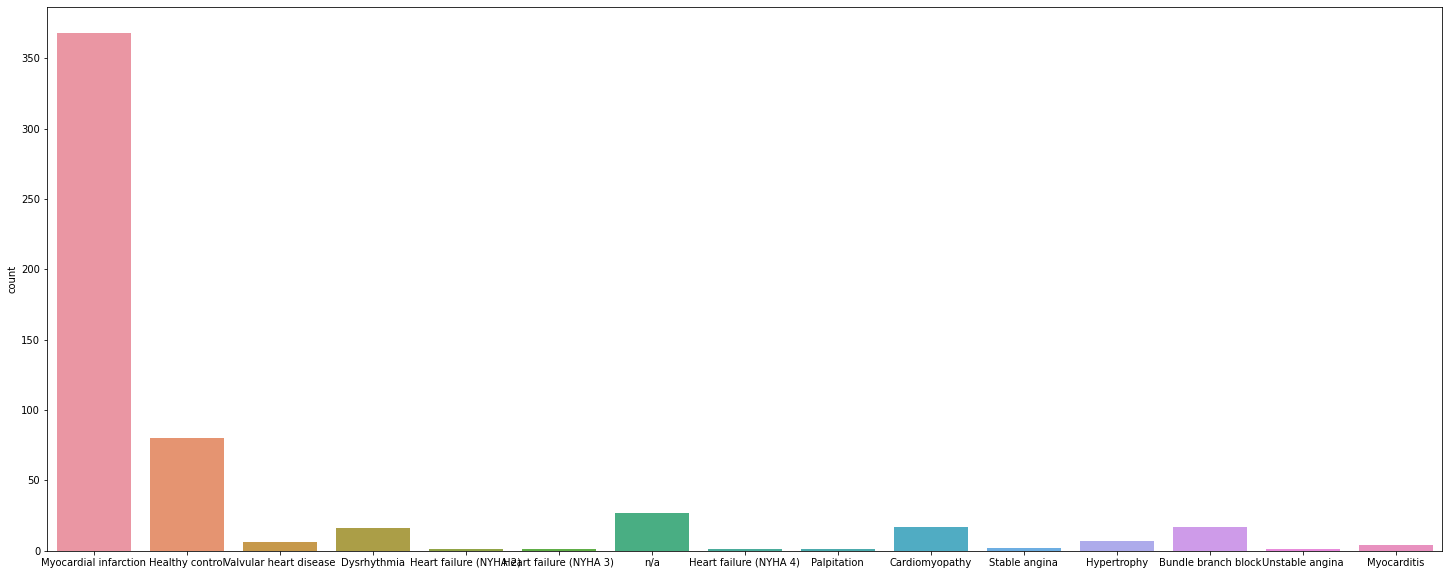

In [10]:
# Visualizing the distribution of classes
labels = []
for rec in records:
    data = wfdb.rdsamp(rec)
    label = " ".join(data[1]['comments'][4].split()[3:])
    labels.append(label)

plt.figure(figsize=(25, 10))
sns.countplot(labels)

Data Cleaning
---

In [11]:
# Removing data with n/a labels
for rec in records:
    data = wfdb.rdsamp(rec)
    label = " ".join(data[1]['comments'][4].split()[3:])
    if label == "n/a":
        records.remove(rec)

# Preprocessing
---

## Denoising

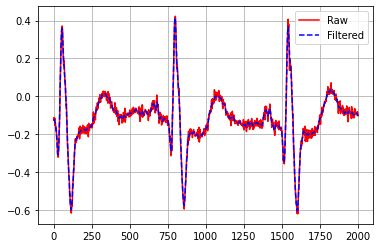

In [12]:
# IIR Filtering
def iir_lp(x, cutoff, fs):
    sos = signal.butter(4, 2*cutoff/fs, output='sos')
    y = signal.sosfiltfilt(sos, x)
    return y

data = wfdb.rdsamp("drive/MyDrive/ml-dataset/patient001/s0010_re", channel_names=['i', 'ii'])[0]

plt.plot(data[:, 0][5000:7000], 'r')
plt.plot(iir_lp(data[:, 0][5000:7000], 50, 1000), 'b--')
plt.grid("on")
plt.legend(["Raw", "Filtered"])

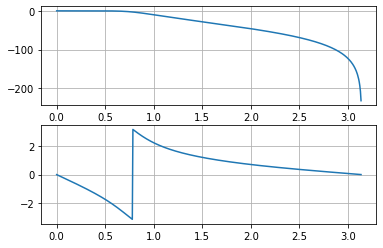

In [13]:
# Frequency response of IIR filter
b, a = signal.butter(4, 0.25, output='ba')
w, h = signal.freqz(b, a)
fig, ax = plt.subplots(2, 1)
ax[0].plot(w, 20*np.log10(np.abs(h)))
ax[0].grid("on")
ax[1].plot(w, np.angle(h))
ax[1].grid("on")

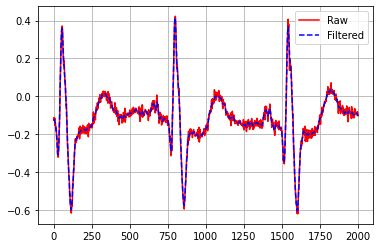

In [14]:
# FIR Filtering 
def fir_lp(x, cutoff, fs):
    h = signal.firwin(255, cutoff, fs=fs)
    y = signal.filtfilt(h, 1, x)
    return y

plt.plot(data[:, 0][5000:7000], 'r')
plt.plot(iir_lp(data[:, 0][5000:7000], 50, 1000), 'b--')
plt.grid("on")
plt.legend(["Raw", "Filtered"])

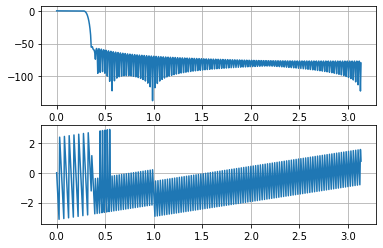

In [15]:
# Frequency response of FIR filter
h = signal.firwin(255, 50, fs=1000)
w, h = signal.freqz(h , 1)
fig, ax = plt.subplots(2, 1)
ax[0].plot(w, 20*np.log10(np.abs(h)))
ax[0].grid("on")
ax[1].plot(w, np.angle(h))
ax[1].grid("on")

Dimensionality Reduction
---

In [16]:
# PCA
data = wfdb.rdsamp("drive/MyDrive/ml-dataset/patient001/s0010_re")[0]

pca = PCA(n_components=0.95)
pca_signal = pca.fit_transform(data)
print(f"Initial dimensions: {data.shape[1]} | Dimension after PCA: {pca_signal.shape[1]}")

Initial dimensions: 15 | Dimension after PCA: 4


In [17]:
def preprocess(x):
    pca = PCA(n_components=10)
    x_pca = pca.fit_transform(x)
    x_filtered = iir_lp(x_pca.T, 50, 1000)
    return x_filtered

data = wfdb.rdsamp("drive/MyDrive/ml-dataset/patient001/s0010_re")[0]
preprocess(data).shape

(10, 38400)

# Train
---

In [18]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, patients_list,
                 batch_size,
                 input_size=(10, 1000, 1),
                 shuffle=True):
        
        self.data_dir = data_dir
        self.patients_list = patients_list
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.patients_list)
        self.__get_recs()
    
    def __get_recs(self,):
        self.records = []
        for patient in self.patients_list:
            dir = Path(self.data_dir) / f"patient{str(patient).zfill(3)}"
            self.records.extend([dir / x[:-4] for x in glob(f"{str(dir)}/*.dat")])
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.records)
    
    def __getitem__(self, index):
        rec = self.records[index]
        signals = preprocess(wfdb.rdsamp(rec)[0])
        if signals.shape[1] < self.batch_size*1000:
            np.pad(signals, ((0, 0),(0, self.batch_size*1000 - signals.shape[1])), 'constant')

        batched_signals = np.array([signals[:, i*1000:(i+1)*1000] for i in range(self.batch_size)])
        labels = " ".join(wfdb.rdsamp(rec)[1]['comments'][4].split()[3:])
        return (batched_signals.reshape(self.batch_size, *self.input_size),
                (np.array(labels) == 'Myocardial infarction').astype(int).repeat(self.batch_size))
    
    def __len__(self):
        return self.n

In [78]:
# Splitting data into train, test, validation
NUM_SUBJECTS = 294
train_patients = np.random.choice(np.arange(1, NUM_SUBJECTS+1), int(0.7*NUM_SUBJECTS), replace=False)

val_patients = np.array([idx for idx in np.arange(1, NUM_SUBJECTS+1) if idx not in train_patients])
val_patients = np.random.choice(val_patients, int(0.15*NUM_SUBJECTS), replace=False)
test_patients = np.array([idx for idx in np.arange(1, NUM_SUBJECTS+1) if idx not in val_patients and idx not in train_patients])



# Generators
train_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", train_patients, 32)
test_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", test_patients, 32)
val_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", val_patients, 32)

In [79]:
train_gen[1][0].shape

(32, 10, 1000, 1)

# Evaluate

In [26]:
def evaluate(model):
  score = model.evaluate(test_gen)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

In [27]:
def plot(history):
  # Get training and test loss histories
  training_loss = history.history['loss']
  training_acc = history.history['accuracy']
  training_recall = history.history['Recall']
  training_precision = history.history['Precision']

  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']
  val_recall = history.history['val_Recall']
  val_precision = history.history['val_Precision']
  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  fig=plt.figure(figsize=(16, 4))

  # Create count of the number of epochs
  epoch_count = range(1, len(val_acc) + 1)

  # Visualize loss history
  fig.add_subplot(141)
  plt.plot(epoch_count, val_loss, 'r--')
  plt.plot(epoch_count, training_loss, 'b-')
  plt.legend(['Validation Loss', 'Training Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  fig.add_subplot(142)
  plt.plot(epoch_count, val_acc, 'r--')
  plt.plot(epoch_count, training_acc, 'b-')
  plt.legend(['Validation Accuracy', 'Training Accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  fig.add_subplot(143)
  plt.plot(epoch_count, val_recall, 'r--')
  plt.plot(epoch_count, training_recall, 'b-')
  plt.legend(['Validation Recall', 'Training Recall'])
  plt.xlabel('Epoch')
  plt.ylabel('Recall')

  fig.add_subplot(144)
  plt.plot(epoch_count, val_precision, 'r--')
  plt.plot(epoch_count, training_precision, 'b-')
  plt.legend(['Validation Precision', 'Training Precision'])
  plt.xlabel('Epoch')
  plt.ylabel('Precision')

  plt.show();

# ANN

In [97]:
ann_model = Sequential()
ann_model.add(Dense(50, activation='relu', input_shape=(10, 1000, 1)))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(GlobalAveragePooling2D())
ann_model.add(Dense(1, activation='sigmoid'))

In [98]:
ann_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 10, 1000, 50)      100       
                                                                 
 dense_21 (Dense)            (None, 10, 1000, 50)      2550      
                                                                 
 dense_22 (Dense)            (None, 10, 1000, 50)      2550      
                                                                 
 dense_23 (Dense)            (None, 10, 1000, 50)      2550      
                                                                 
 global_average_pooling2d_4   (None, 50)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_24 (Dense)            (None, 1)                 51        
                                                      

In [99]:
ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),])
history0 = ann_model.fit(train_gen, batch_size=32, epochs=5,validation_data=val_gen)

Epoch 1/5
205/205 [==============================] - 130s 628ms/step - loss: 0.6723 - accuracy: 0.6258 - Recall: 0.9385 - Precision: 0.6417 - val_loss: 0.6268 - val_accuracy: 0.6818 - val_Recall: 1.0000 - val_Precision: 0.6818
Epoch 2/5
205/205 [==============================] - 137s 670ms/step - loss: 0.6470 - accuracy: 0.6585 - Recall: 1.0000 - Precision: 0.6585 - val_loss: 0.5633 - val_accuracy: 0.7727 - val_Recall: 1.0000 - val_Precision: 0.7727
Epoch 3/5
205/205 [==============================] - 125s 611ms/step - loss: 0.6241 - accuracy: 0.6829 - Recall: 1.0000 - Precision: 0.6829 - val_loss: 0.6198 - val_accuracy: 0.7045 - val_Recall: 1.0000 - val_Precision: 0.7045
Epoch 4/5
205/205 [==============================] - 121s 590ms/step - loss: 0.6601 - accuracy: 0.6293 - Recall: 1.0000 - Precision: 0.6293 - val_loss: 0.6209 - val_accuracy: 0.7045 - val_Recall: 1.0000 - val_Precision: 0.7045
Epoch 5/5
205/205 [==============================] - 122s 594ms/step - loss: 0.6261 - accura

45/45 [==============================] - 23s 508ms/step - loss: 0.5786 - accuracy: 0.7111 - Recall: 1.0000 - Precision: 0.7111
Test loss: 0.5785666704177856
Test accuracy: 0.7111111283302307


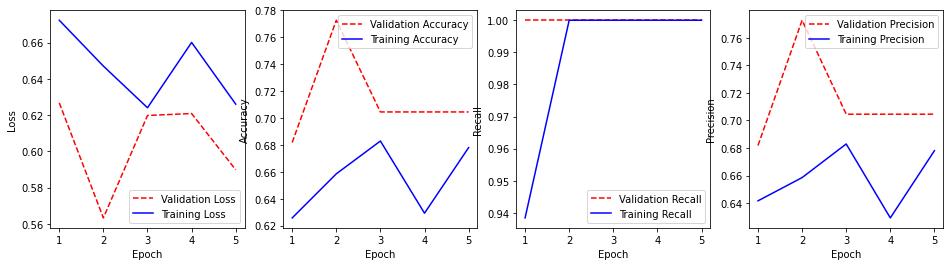

In [100]:
evaluate(ann_model)
plot(history0)

# CNN 

In [101]:
def get_base_model():
  return keras.Sequential([
    keras.layers.Conv2D(256, 3, activation="relu", input_shape=(10, 1000, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=3, padding="same"),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(15, activation='relu', input_shape=(10, 1000, 1), kernel_regularizer=regularizers.l2(0.000001)),
    keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.000001)),
    keras.layers.Dense(5, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid'))                   
  ])

In [102]:
model = get_base_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_126 (Conv2D)         (None, 8, 998, 256)       2560      
                                                                 
 batch_normalization_126 (Ba  (None, 8, 998, 256)      1024      
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 3, 333, 256)      0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 3, 333, 256)       0         
                                                                 
 flatten_4 (Flatten)         (None, 255744)            0         
                                                                 
 dense_25 (Dense)            (None, 15)               

In [103]:
model = get_base_model() 
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),])
history1 = model.fit(train_gen, batch_size=32, epochs=5,validation_data=val_gen)

Epoch 1/5
205/205 [==============================] - 121s 584ms/step - loss: 1.7627 - accuracy: 0.6134 - Recall: 0.9356 - Precision: 0.6298 - val_loss: 0.6822 - val_accuracy: 0.6768 - val_Recall: 0.9927 - val_Precision: 0.6802
Epoch 2/5
205/205 [==============================] - 122s 595ms/step - loss: 0.6935 - accuracy: 0.6447 - Recall: 0.9969 - Precision: 0.6432 - val_loss: 0.6389 - val_accuracy: 0.7038 - val_Recall: 0.9980 - val_Precision: 0.7046
Epoch 3/5
205/205 [==============================] - 119s 580ms/step - loss: 0.6661 - accuracy: 0.6245 - Recall: 1.0000 - Precision: 0.6226 - val_loss: 0.6177 - val_accuracy: 0.7500 - val_Recall: 1.0000 - val_Precision: 0.7500
Epoch 4/5
205/205 [==============================] - 122s 598ms/step - loss: 0.6571 - accuracy: 0.6633 - Recall: 0.9995 - Precision: 0.6618 - val_loss: 0.6251 - val_accuracy: 0.6591 - val_Recall: 1.0000 - val_Precision: 0.6591
Epoch 5/5
205/205 [==============================] - 120s 586ms/step - loss: 0.6775 - accura

45/45 [==============================] - 21s 469ms/step - loss: 0.5549 - accuracy: 0.7563 - Recall: 1.0000 - Precision: 0.7561
Test loss: 0.5549065470695496
Test accuracy: 0.7562500238418579


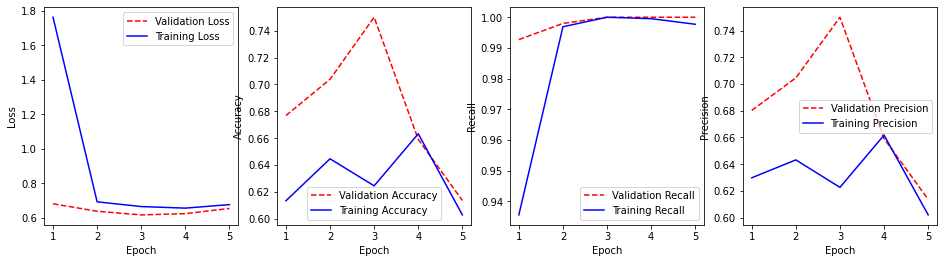

In [104]:
evaluate(model)
plot(history1)

# Lenet5

In [80]:
lenet_5_model=Sequential()

lenet_5_model.add(Conv2D(filters=6, kernel_size=3, padding='same', input_shape=(10, 1000, 1)))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool2D(pool_size=3, strides=2, padding='same'))

lenet_5_model.add(Conv2D(filters=6, strides=1, kernel_size=5))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool2D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(Conv2D(filters=6, kernel_size=3, padding='same'))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool2D(pool_size=3, strides=2, padding='same'))

lenet_5_model.add(Conv2D(filters=6, kernel_size=3, padding='same'))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))

lenet_5_model.add(GlobalAveragePooling2D())


lenet_5_model.add(tf.keras.layers.Flatten()) 
lenet_5_model.add(Dense(64, activation='relu'))

lenet_5_model.add(Dense(32, activation='relu'))

lenet_5_model.add(Dense(1, activation = 'sigmoid'))

In [96]:
lenet_5_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 10, 1000, 6)       60        
                                                                 
 batch_normalization_2 (Batc  (None, 10, 1000, 6)      24        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 10, 1000, 6)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 500, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 496, 6)         906       
                                                                 
 batch_normalization_3 (Batc  (None, 1, 496, 6)       

In [81]:
lenet_5_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),])

In [82]:
history3 = lenet_5_model.fit(train_gen, batch_size=32, epochs=5,validation_data=val_gen)

Epoch 1/5
205/205 [==============================] - 124s 595ms/step - loss: 0.6626 - accuracy: 0.6206 - Recall: 0.9939 - Precision: 0.6230 - val_loss: 0.6784 - val_accuracy: 0.6364 - val_Recall: 1.0000 - val_Precision: 0.6364
Epoch 2/5
205/205 [==============================] - 124s 604ms/step - loss: 0.6192 - accuracy: 0.6439 - Recall: 1.0000 - Precision: 0.6439 - val_loss: 0.5538 - val_accuracy: 0.7500 - val_Recall: 1.0000 - val_Precision: 0.7500
Epoch 3/5
205/205 [==============================] - 123s 601ms/step - loss: 0.6337 - accuracy: 0.6244 - Recall: 1.0000 - Precision: 0.6244 - val_loss: 0.6126 - val_accuracy: 0.7045 - val_Recall: 1.0000 - val_Precision: 0.7045
Epoch 4/5
205/205 [==============================] - 123s 601ms/step - loss: 0.6480 - accuracy: 0.6195 - Recall: 1.0000 - Precision: 0.6195 - val_loss: 0.6498 - val_accuracy: 0.6364 - val_Recall: 1.0000 - val_Precision: 0.6364
Epoch 5/5
205/205 [==============================] - 124s 604ms/step - loss: 0.5986 - accura

45/45 [==============================] - 22s 500ms/step - loss: 0.1684 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000
Test loss: 0.16842931509017944
Test accuracy: 1.0


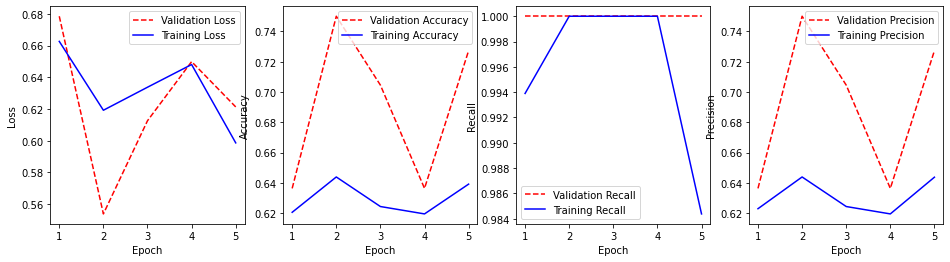

In [83]:
evaluate(lenet_5_model)
plot(history3)

# ResNet

In [86]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    X = Conv2D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv2D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv2D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)
    
    X = Conv2D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv2D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv2D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X
def ResNet18(input_shape):
    
    X_input = Input(input_shape)

    X = ZeroPadding2D(3)(X_input)
    
    X = Conv2D(64, 7, strides = 2)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool2D(pool_size=2, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling2D()(X)
    X = Dense(1,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [95]:
resNet18_model = ResNet18(input_shape = (10, 1000, 1))
resNet18_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 1000, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 16, 1006, 1)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_73 (Conv2D)             (None, 5, 500, 64)   3200        ['zero_padding2d_1[0][0]']       
                                                                                           

In [88]:
resNet18_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),])

In [89]:
history2 = resNet18_model.fit(train_gen, batch_size=32, epochs=5,validation_data=val_gen)

Epoch 1/5
205/205 [==============================] - 147s 670ms/step - loss: 1.2436 - accuracy: 0.5386 - Recall: 0.6435 - Precision: 0.6237 - val_loss: 0.6381 - val_accuracy: 0.6825 - val_Recall: 1.0000 - val_Precision: 0.6823
Epoch 2/5
205/205 [==============================] - 134s 651ms/step - loss: 0.7894 - accuracy: 0.6111 - Recall: 0.7750 - Precision: 0.6923 - val_loss: 5.7681 - val_accuracy: 0.6357 - val_Recall: 0.9989 - val_Precision: 0.6361
Epoch 3/5
205/205 [==============================] - 132s 645ms/step - loss: 0.9034 - accuracy: 0.5997 - Recall: 0.7507 - Precision: 0.6822 - val_loss: 1.0976 - val_accuracy: 0.7216 - val_Recall: 0.9922 - val_Precision: 0.7257
Epoch 4/5
205/205 [==============================] - 133s 646ms/step - loss: 0.8221 - accuracy: 0.5890 - Recall: 0.7736 - Precision: 0.6579 - val_loss: 7.9506 - val_accuracy: 0.5334 - val_Recall: 0.5312 - val_Precision: 0.5562
Epoch 5/5
205/205 [==============================] - 132s 642ms/step - loss: 0.8593 - accura

45/45 [==============================] - 23s 515ms/step - loss: 32.0698 - accuracy: 0.5076 - Recall: 0.5756 - Precision: 0.6647
Test loss: 32.069786071777344
Test accuracy: 0.5076388716697693


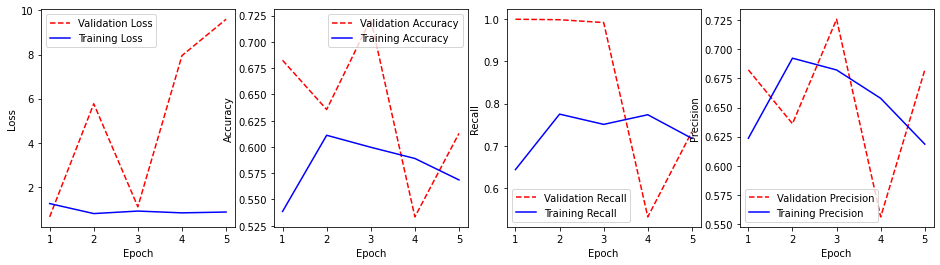

In [90]:
evaluate(resNet18_model)
plot(history2)

# VGG

In [91]:
vgg_16_model=Sequential()

vgg_16_model.add(Conv2D(filters=64, kernel_size=3, padding='same',  input_shape=(10, 1000, 1)))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv2D(filters=64, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool2D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv2D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv2D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool2D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv2D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv2D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv2D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool2D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv2D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv2D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv2D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool2D(pool_size=2, strides=2, padding='same'))
vgg_16_model.add(Conv2D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv2D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv2D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool2D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(GlobalAveragePooling2D())
vgg_16_model.add(Dense(256, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(128, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(1, activation='sigmoid'))

In [93]:
vgg_16_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 10, 1000, 64)      640       
                                                                 
 batch_normalization_60 (Bat  (None, 10, 1000, 64)     256       
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 10, 1000, 64)      0         
                                                                 
 conv2d_61 (Conv2D)          (None, 10, 1000, 64)      36928     
                                                                 
 batch_normalization_61 (Bat  (None, 10, 1000, 64)     256       
 chNormalization)                                                
                                                                 
 activation_22 (Activation)  (None, 10, 1000, 64)     

In [92]:
vgg_16_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),])
history4 = vgg_16_model.fit(train_gen, batch_size=32, epochs=5,validation_data=val_gen)

Epoch 1/5
205/205 [==============================] - 133s 627ms/step - loss: 0.7076 - accuracy: 0.6003 - Recall: 0.8903 - Precision: 0.6332 - val_loss: 0.7110 - val_accuracy: 0.7045 - val_Recall: 1.0000 - val_Precision: 0.7045
Epoch 2/5
205/205 [==============================] - 128s 625ms/step - loss: 0.6617 - accuracy: 0.6174 - Recall: 0.9688 - Precision: 0.6249 - val_loss: 1.4388 - val_accuracy: 0.6136 - val_Recall: 1.0000 - val_Precision: 0.6136
Epoch 3/5
205/205 [==============================] - 128s 622ms/step - loss: 0.6514 - accuracy: 0.6723 - Recall: 0.9980 - Precision: 0.6730 - val_loss: 0.6071 - val_accuracy: 0.7500 - val_Recall: 1.0000 - val_Precision: 0.7500
Epoch 4/5
205/205 [==============================] - 128s 622ms/step - loss: 0.6742 - accuracy: 0.6244 - Recall: 1.0000 - Precision: 0.6244 - val_loss: 0.6463 - val_accuracy: 0.6591 - val_Recall: 1.0000 - val_Precision: 0.6591
Epoch 5/5
205/205 [==============================] - 129s 628ms/step - loss: 0.6630 - accura

59/59 [==============================] - 29s 495ms/step - loss: 0.2926 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000
Test loss: 0.29261213541030884
Test accuracy: 1.0


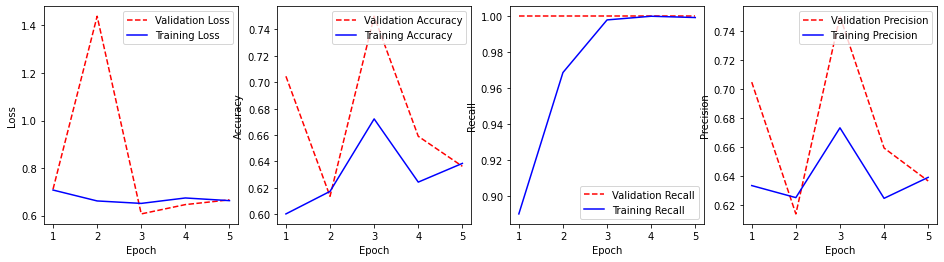

In [119]:
evaluate(vgg_16_model)
plot(history4)

# Cross validation

In [117]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import copy

def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array):

    model_ = copy.deepcopy(model)
       
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    accuracy = np.empty([0], dtype=int)

    for train_ndx, test_ndx in kfold.split(X):
        # Extracts the rows from the data for the training and testing
        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]
        # Appends the actual target classifications to actual_classes
        actual_classes = np.append(actual_classes, test_y)
        # Fits the machine learning model using the training data extracted from the current fold
        history = model_.fit(train_X, train_y, batch_size=32, epochs=5)
        # Uses the fitted model to predict the target classifications for the test data in the current fold
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))
        accuracy = np.append(accuracy, accuracy_score(actual_classes, predicted_classes))
       
    return actual_classes, predicted_classes, accuracy.mean(), model_, history


In [105]:
# Splitting data into train, test, validation
NUM_SUBJECTS = 294
train_patients = np.random.choice(np.arange(1, NUM_SUBJECTS+1), int(0.8*NUM_SUBJECTS), replace=False)

test_patients = np.array([idx for idx in np.arange(1, NUM_SUBJECTS+1) if idx not in train_patients])



# Generators
train_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", train_patients, 32)
test_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", test_patients, 32)

## lenet5 with cross validation

In [106]:
model_cross = lenet_5_model
model_cross.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),])

In [65]:
x_shape = train_gen[0][0].shape
X = np.empty(x_shape)
for i in range(train_patients.shape[0]):
  X = np.append(X,train_gen[i][0],axis=0)

In [68]:
X.shape

(7552, 10, 1000, 1)

In [77]:
train_gen[0][0].shape

(32, 10, 1000, 1)

In [66]:
y_shape = train_gen[0][1].shape
Y = np.empty(y_shape)
for i in range(train_patients.shape[0]):
  Y = np.append(Y,train_gen[i][1],axis=0)

In [118]:
Y.shape

(7552,)

In [ ]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
actual_classes, predicted_classes, accuracy, model_cross, history_cross = cross_val_predict(model_cross, kfold, X,Y)

15/15 [==============================] - 7s 441ms/step - loss: 0.7794 - accuracy: 0.5333 - Recall: 1.0000 - Precision: 0.5333
Test loss: 0.7794217467308044
Test accuracy: 0.5333333611488342


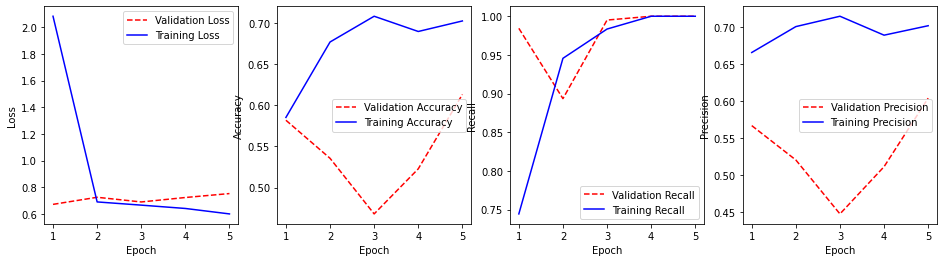

In [ ]:
evaluate(model_cross)
plot(history_cross)